In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess as sub
import torch
import torchvision
import random
import time

from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision import datasets, models, transforms

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#print("PyTorch Version: ",torch.__version__)
#print("Torchvision Version: ", torchvision.__version__)

## Image loading

In [2]:
# Set train and test paths
train_directory = 'train_2types/'
test_directory = 'test_2types/'

# Define a set of transformations to augment the data
image_transforms = { 'train': transforms.Compose([
        transforms.RandomResizedCrop(size=512, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [3]:
image_transforms

{'train': Compose(
     RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
     RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
     RandomHorizontalFlip(p=0.5)
     Resize(size=224, interpolation=PIL.Image.BILINEAR)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'test': Compose(
     Resize(size=224, interpolation=PIL.Image.BILINEAR)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [4]:
# Batch size
bs = 64
 
# Number of classes
num_classes = 2

In [5]:
# A class that facilitates the retrieval of location paths for the input.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. 
    Extends torchvision.datasets.ImageFolder
    """
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
# Load Data from folders
data = {'train': ImageFolderWithPaths(root=train_directory, transform=image_transforms['train']),
         'test': ImageFolderWithPaths(root=test_directory, transform=image_transforms['test'])}

In [7]:
data

{'train': Dataset ImageFolderWithPaths
     Number of datapoints: 1185
     Root location: train_2types/
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
                RandomHorizontalFlip(p=0.5)
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolderWithPaths
     Number of datapoints: 482
     Root location: test_2types/
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [8]:
# Size of Data, to be used for calculating Average Loss and Accuracy
dataset_sizes = {'train': len(data['train']), 'test': len(data['test'])}

In [9]:
dataset_sizes

{'train': 1185, 'test': 482}

## Metadata loading

In [10]:
# Load training metadata
df = pd.read_csv("metadata.tsv", sep = "\t")

In [11]:
df_train = df[(df["dataset"] == "train") & (df["Tissue"].isin(["Skin", "Liver"]))].reset_index(drop = True)
#df_train

In [12]:
#df_test = df[(df["dataset"] == "test") & (df["Tissue"].isin(["Skin", "Liver"]))].reset_index(drop = True)
#df_test

In [13]:
# Load training metadata
#train_sample_meta = pd.read_csv("metadata.tsv", sep = "\t")
#train_sample_meta = train_sample_meta[train_sample_meta["dataset"] == "train"].sort_values(['Tissue', 'Tile']).reset_index(drop = True)
train_sample_meta = df_train

# Compute how many tiles per class
class_sample_counts = pd.DataFrame(train_sample_meta["Tissue"].value_counts().sort_index()).reset_index(drop=False)
class_sample_counts.rename({"index": "Tissue", "Tissue":"class_tiles"}, axis = 1, inplace=True)
train_sample_meta = train_sample_meta.merge(class_sample_counts, how="left", on="Tissue")

# Add a weight vector for weighted random sampling for the training dataloader
train_sample_meta["weight"] = 1/train_sample_meta["class_tiles"]

weights = torch.Tensor(train_sample_meta["weight"].values)
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, dataset_sizes["train"])

In [14]:
dataloaders = {'train': torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=False, sampler=weighted_sampler),
                'test': torch.utils.data.DataLoader(data['test'], batch_size=bs, shuffle=True)}

In [15]:
#dataloaders = {'train': torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=False),
#                'test': torch.utils.data.DataLoader(data['test'], batch_size=bs, shuffle=True)}

In [16]:
data["train"].classes

['Liver', 'Skin']

In [17]:
# Iterate through the train data and store the distribution of classes per batch
label_mapper = dict(zip(range(0, len(data["train"].classes)), data["train"].classes))

In [18]:
label_mapper

{0: 'Liver', 1: 'Skin'}

In [19]:
# Load pretrained Inception Model
#model = models.resnet152(pretrained=True)
model = models.resnet50(pretrained=True)
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


We will perform transfer learning by freezing the network, and changing the final FC layer from ResNet. Training will be first performed for this layer.

In [20]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

In [21]:
# Change the final fully connected layer of ResNet Model for Transfer Learning.
# Initialy, we will train only the new sequential layer.
fc_inputs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(fc_inputs, 1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1000, num_classes), 
    torch.nn.LogSoftmax(dim=1)) # For using NLLLoss()

In [22]:
# Convert model to be used on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
# Define Optimizer, loss Function, learning rate scheduler, and epochs
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
epochs = 6

Define a function to train the model:

In [24]:
def train_model(model, criterion, optimizer, scheduler, datasets, dataset_sizes, device, num_epochs=3):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    metrics = {"train": {"loss": [], "acc": []}, 
               "test" : {"loss": [], "acc": []}}

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, epochs))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval() # Set to evaluation mode

            running_loss = 0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels, paths) in enumerate(datasets[phase]):

                # push input to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            metrics[phase]["loss"].append(epoch_loss)
            metrics[phase]["acc"].append(epoch_acc.cpu().numpy().item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if scheduler is not None:
            scheduler.step()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, metrics

Train the model (training might fail if Colab assigns a GPU without enough memory):

In [25]:
model, metrics = train_model(model, loss_func, optimizer, lr_scheduler, 
                             dataloaders, dataset_sizes, device, epochs)

Epoch: 1/6
----------
train Loss: 0.7822 Acc: 0.6321
test Loss: 0.5583 Acc: 0.6846

Epoch: 2/6
----------
train Loss: 0.2808 Acc: 0.8827
test Loss: 0.4139 Acc: 0.7988

Epoch: 3/6
----------
train Loss: 0.2348 Acc: 0.9139
test Loss: 0.4337 Acc: 0.7863

Epoch: 4/6
----------
train Loss: 0.2164 Acc: 0.9215
test Loss: 0.4331 Acc: 0.7967

Epoch: 5/6
----------
train Loss: 0.2217 Acc: 0.9232
test Loss: 0.4302 Acc: 0.7925

Epoch: 6/6
----------
train Loss: 0.2119 Acc: 0.9241
test Loss: 0.4480 Acc: 0.7822

Training complete in 29m 5s
Best val Acc: 0.798755


Now we will unfreeze the rest of the network and train everything.

In [26]:
# Un-freeze model parameters
for param in model.parameters():
    param.requires_grad = True
    
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Finetune the whole network
epochs = 10
model, metrics = train_model(model, loss_func, optimizer, lr_scheduler, 
                             dataloaders, dataset_sizes, device, epochs)

Epoch: 1/10
----------
train Loss: 0.3642 Acc: 0.8886
test Loss: 2.2828 Acc: 0.5643

Epoch: 2/10
----------
train Loss: 0.1138 Acc: 0.9662
test Loss: 0.0052 Acc: 1.0000

Epoch: 3/10
----------
train Loss: 0.0854 Acc: 0.9688
test Loss: 0.0856 Acc: 0.9689

Epoch: 4/10
----------
train Loss: 0.0561 Acc: 0.9831
test Loss: 0.0405 Acc: 0.9834

Epoch: 5/10
----------
train Loss: 0.0486 Acc: 0.9831
test Loss: 0.0222 Acc: 0.9938

Epoch: 6/10
----------
train Loss: 0.0296 Acc: 0.9916
test Loss: 0.0075 Acc: 0.9979

Epoch: 7/10
----------
train Loss: 0.0458 Acc: 0.9857
test Loss: 0.0063 Acc: 1.0000

Epoch: 8/10
----------
train Loss: 0.0406 Acc: 0.9890
test Loss: 0.0090 Acc: 0.9979

Epoch: 9/10
----------
train Loss: 0.0524 Acc: 0.9797
test Loss: 0.0065 Acc: 1.0000

Epoch: 10/10
----------
train Loss: 0.0404 Acc: 0.9882
test Loss: 0.0118 Acc: 0.9979

Training complete in 154m 16s
Best val Acc: 1.000000


In [27]:
torch.save(model, os.path.join(os.getcwd(), 'finetuned_resnet50_liver_skin'))

In [28]:
metrics["train"]["acc"]

[0.8886075949367088,
 0.9662447257383966,
 0.9687763713080169,
 0.9831223628691983,
 0.9831223628691983,
 0.9915611814345991,
 0.9856540084388186,
 0.9890295358649789,
 0.979746835443038,
 0.9881856540084388]

In [29]:
metrics["test"]["acc"]

[0.5643153526970954,
 1.0,
 0.9688796680497925,
 0.983402489626556,
 0.9937759336099585,
 0.9979253112033195,
 1.0,
 0.9979253112033195,
 1.0,
 0.9979253112033195]

In [30]:
metrics["train"]["loss"]

[0.36416611914770514,
 0.1138209402152506,
 0.08541401895666927,
 0.05614423109257775,
 0.048617595321015464,
 0.02962666619804841,
 0.04584976005277553,
 0.04059626051472335,
 0.05244237490721393,
 0.04035237325583329]

In [31]:
metrics["test"]["loss"]

[2.2827823468758357,
 0.005231956317798617,
 0.08556627942813383,
 0.04047132941944471,
 0.02218015972888136,
 0.007540796326929356,
 0.006270722209773494,
 0.008955987189660676,
 0.0065431132201584545,
 0.011834957980825199]

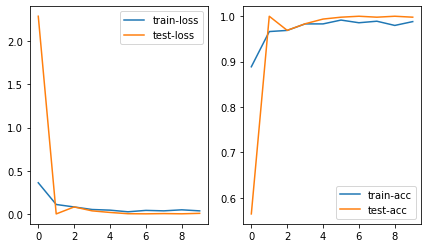

In [44]:
fig, ax = plt.subplots(1,2,figsize=(7,4))
ax[0].plot(metrics["train"]["loss"], label='train-loss')
ax[0].plot(metrics["test"]["loss"], label='test-loss')

ax[1].plot(metrics["train"]["acc"], label='train-acc')
ax[1].plot(metrics["test"]["acc"], label='test-acc')
ax[0].legend()
ax[1].legend()

In [32]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
## load trained model
#model_trained = torch.load(os.path.join(os.getcwd(), 'finetuned_resnet50_liver_skin'))